# This file determines what part of the Busch cells the given coordinate position corresponds to

Problem:
- Busch dataset uses grid cells which include a coordinate for each point but do not specify where the cell is in reference to that point: thus it could be any one of the 4 corners or the center or something else entirely

Process:
- take the grid points which are on the border of Indonesia, e.g. are next to water
- cells at these points will have a different land area based which reference point is correct (e.g. contain more or less water)
- can calculate what the areas would be for each of the reference points and compare it to the area of each cell given by Busch

Results:
- after plotting residuals, it is evident that the center point is the reference point, e.g. the given coordinate for each cell is the center of the cell
- excel plot of residuals is shown in 'outputs/filtered_subset_analysis.xlsx' file
- cells.pptx illustrates some steps of this process 


In [95]:
# imports
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import descartes
from shapely.geometry import Point, Polygon
import random

mpl.rcParams['figure.dpi'] = 600 # set dpi

indonesia = gpd.read_file("data/indonesia_boundary.json")
grid = pd.read_csv("data/grid_coords.csv")
indonesia_shape = indonesia["geometry"][0]

# getting exteriors
indonesia_shape_exteriors = []
for geom in indonesia_shape.geoms:
    indonesia_shape_exteriors.append(geom.exterior)

In [150]:
# only consider coords near boundary: cell area < 900 and within 6 km of boundary
# 1km is going to equal roughly 0.008 degrees (1 km / 40,000 km * 360 degrees) 
in_contention = []
for i in range(len(grid)):
    if grid["area"][i] < 900:
        in_contention.append(grid.index[i])
filtered = grid.iloc[in_contention, :]

# pick a random small subset of them to run the cell intersection calculations on
random_subset_inds = random.sample(range(len(filtered)), k=1000)
filtered_subset = filtered.iloc[random_subset_inds, :].reset_index(drop=True)

# filtered_subset = filtered.reset_index(drop=True)

print(len(filtered_subset))
remove = []
for i in range(len(filtered_subset)):
    # print(min([geom.distance(Point(filtered_subset["geo_x"][i], filtered_subset["geo_y"][i])) for geom in indonesia_shape_exteriors]))
    near_boundary = any([geom.distance(Point(filtered_subset["geo_x"][i], filtered_subset["geo_y"][i])) < 0.008*6 for geom in indonesia_shape_exteriors])
    # print(near_boundary)
    if not near_boundary:
        remove.append(i)
        print(i)
print('removing', len(remove))
filtered_subset.drop(index=remove, inplace=True)
filtered_subset


1000
12
16
24
51
57
70
74
80
88
94
95
101
128
144
145
147
149
150
151
184
186
189
190
193
196
212
218
227
231
233
241
245
256
268
277
289
290
292
294
300
302
309
311
316
320
323
325
326
328
330
335
339
344
349
373
375
377
384
398
399
402
415
422
428
430
434
435
446
451
465
471
472
473
507
514
541
542
546
554
563
568
571
572
576
585
586
591
598
599
605
606
609
625
631
632
644
651
658
659
666
667
671
688
690
694
711
720
723
724
725
732
737
743
749
758
770
777
778
786
799
800
802
809
817
819
826
831
832
859
860
879
880
881
883
897
899
908
917
918
924
933
950
952
958
973
976
978
979
996
999
removing 150


,id,cellcode,geo_x,geo_y,area
0,66350,208294,120.0735,-8.3874,361.0
1,104117,252426,122.5728,-1.2526,577.0
2,156909,313245,140.9907,-5.5662,319.0
3,193285,355702,127.8009,-0.3301,786.0
4,139510,290145,117.8531,2.1117,871.0
...,...,...,...,...,...
993,134925,285191,113.5715,1.2978,651.0
994,75225,220567,122.9124,-4.4539,356.0
995,72131,215703,112.7886,-7.0040,843.0
997,145254,296723,115.6565,4.0108,509.0


In [155]:
# conversions: https://stackoverflow.com/questions/1253499/simple-calculations-for-working-with-lat-lon-and-km-distance#:~:text=The%20approximate%20conversions%20are%3A,111.320*cos(latitude)%20km
# geo_x	longitude; higher is eastward
# geo_y	latitude; higher is northward
# 3 km longitutde = 3 / (111.320*cos(latitude)) deg
# 3 km latitude = 3 / 110.574 deg
filtered_subset.reset_index(drop=True, inplace=True)

# bl = bottom left, br = bottom right, tl = top left, tr = top right, center = center
coords, center_squares, bl_squares, br_squares, tl_squares, tr_squares, area_degs_estimates = [], [], [], [], [], [], []
for i in range(len(filtered_subset)):
    x, y = filtered_subset['geo_x'][i], filtered_subset['geo_y'][i]
    dx, dy = 3/(111.320*np.cos(np.deg2rad(y))), 3/110.574
    coords.append(Point(x, y))
    bl_squares.append(Polygon([(x, y), (x, y+dy), (x+dx, y+dy), (x+dx, y)]))
    br_squares.append(Polygon([(x, y), (x, y+dy), (x-dx, y+dy), (x-dx, y)]))
    tl_squares.append(Polygon([(x, y), (x, y-dy), (x+dx, y-dy), (x+dx, y)]))
    tr_squares.append(Polygon([(x, y), (x, y-dy), (x-dx, y-dy), (x-dx, y)]))
    center_squares.append(Polygon([(x-dx/2, y-dy/2), (x-dx/2, y+dy/2), (x+dx/2, y+dy/2), (x+dx/2, y-dy/2)]))

    # use the area of the center square as an estimate (is supposed to approximate out of 900 ha)
    area_degs_estimates.append(center_squares[-1].area * (filtered_subset['area'][i]/900))

filtered_subset['area_degs_estimate'] = area_degs_estimates
filtered_subset['coord'] = coords
filtered_subset['bl_square'] = bl_squares
filtered_subset['br_square'] = br_squares
filtered_subset['tl_square'] = tl_squares
filtered_subset['tr_square'] = tr_squares
filtered_subset['center_square'] = center_squares
filtered_subset = gpd.GeoDataFrame(filtered_subset)

cell_options = ("bl_square", "br_square", "tl_square", "tr_square", "center_square") 
filtered_subset

,id,cellcode,geo_x,geo_y,area,area_degs_estimate,coord,bl_square,br_square,tl_square,tr_square,center_square
0,66350,208294,120.0735,-8.3874,361.0,0.000296,POINT (120.0735 -8.3874),"POLYGON ((120.0735 -8.3874, 120.0735 -8.360268...","POLYGON ((120.0735 -8.3874, 120.0735 -8.360268...","POLYGON ((120.0735 -8.3874, 120.0735 -8.414531...","POLYGON ((120.0735 -8.3874, 120.0735 -8.414531...",POLYGON ((120.0598796550823 -8.400965575994356...
1,104117,252426,122.5728,-1.2526,577.0,0.000469,POINT (122.5728 -1.2526),"POLYGON ((122.5728 -1.2526, 122.5728 -1.225468...","POLYGON ((122.5728 -1.2526, 122.5728 -1.225468...","POLYGON ((122.5728 -1.2526, 122.5728 -1.279731...","POLYGON ((122.5728 -1.2526, 122.5728 -1.279731...",POLYGON ((122.5593221116467 -1.266165575994357...
2,156909,313245,140.9907,-5.5662,319.0,0.000260,POINT (140.9907 -5.5662),"POLYGON ((140.9907 -5.5662, 140.9907 -5.539068...","POLYGON ((140.9907 -5.5662, 140.9907 -5.539068...","POLYGON ((140.9907 -5.5662, 140.9907 -5.593331...","POLYGON ((140.9907 -5.5662, 140.9907 -5.593331...",POLYGON ((140.9771614955245 -5.579765575994357...
3,193285,355702,127.8009,-0.3301,786.0,0.000639,POINT (127.8009 -0.3301),"POLYGON ((127.8009 -0.3301, 127.8009 -0.302968...","POLYGON ((127.8009 -0.3301, 127.8009 -0.302968...","POLYGON ((127.8009 -0.3301, 127.8009 -0.357231...","POLYGON ((127.8009 -0.3301, 127.8009 -0.357231...",POLYGON ((127.7874251087401 -0.343665575994356...
4,139510,290145,117.8531,2.1117,871.0,0.000708,POINT (117.8531 2.1117),"POLYGON ((117.8531 2.1117, 117.8531 2.13883115...","POLYGON ((117.8531 2.1117, 117.8531 2.13883115...","POLYGON ((117.8531 2.1117, 117.8531 2.08456884...","POLYGON ((117.8531 2.1117, 117.8531 2.08456884...","POLYGON ((117.8396161753773 2.098134424005643,..."
...,...,...,...,...,...,...,...,...,...,...,...,...
845,134925,285191,113.5715,1.2978,651.0,0.000529,POINT (113.5715 1.2978),"POLYGON ((113.5715 1.2978, 113.5715 1.32493115...","POLYGON ((113.5715 1.2978, 113.5715 1.32493115...","POLYGON ((113.5715 1.2978, 113.5715 1.27066884...","POLYGON ((113.5715 1.2978, 113.5715 1.27066884...","POLYGON ((113.5580218749627 1.284234424005643,..."
846,75225,220567,122.9124,-4.4539,356.0,0.000290,POINT (122.9124 -4.4539),"POLYGON ((122.9124 -4.4539, 122.9124 -4.426768...","POLYGON ((122.9124 -4.4539, 122.9124 -4.426768...","POLYGON ((122.9124 -4.4539, 122.9124 -4.481031...","POLYGON ((122.9124 -4.4539, 122.9124 -4.481031...",POLYGON ((122.8988845174963 -4.467465575994357...
847,72131,215703,112.7886,-7.0040,843.0,0.000690,POINT (112.7886 -7.004),"POLYGON ((112.7886 -7.004, 112.7886 -6.9768688...","POLYGON ((112.7886 -7.004, 112.7886 -6.9768688...","POLYGON ((112.7886 -7.004, 112.7886 -7.0311311...","POLYGON ((112.7886 -7.004, 112.7886 -7.0311311...",POLYGON ((112.7750240235671 -7.017565575994356...
848,145254,296723,115.6565,4.0108,509.0,0.000415,POINT (115.6565 4.0108),"POLYGON ((115.6565 4.0108, 115.6565 4.03793115...","POLYGON ((115.6565 4.0108, 115.6565 4.03793115...","POLYGON ((115.6565 4.0108, 115.6565 3.98366884...","POLYGON ((115.6565 4.0108, 115.6565 3.98366884...","POLYGON ((115.6429922503259 3.997234424005643,..."


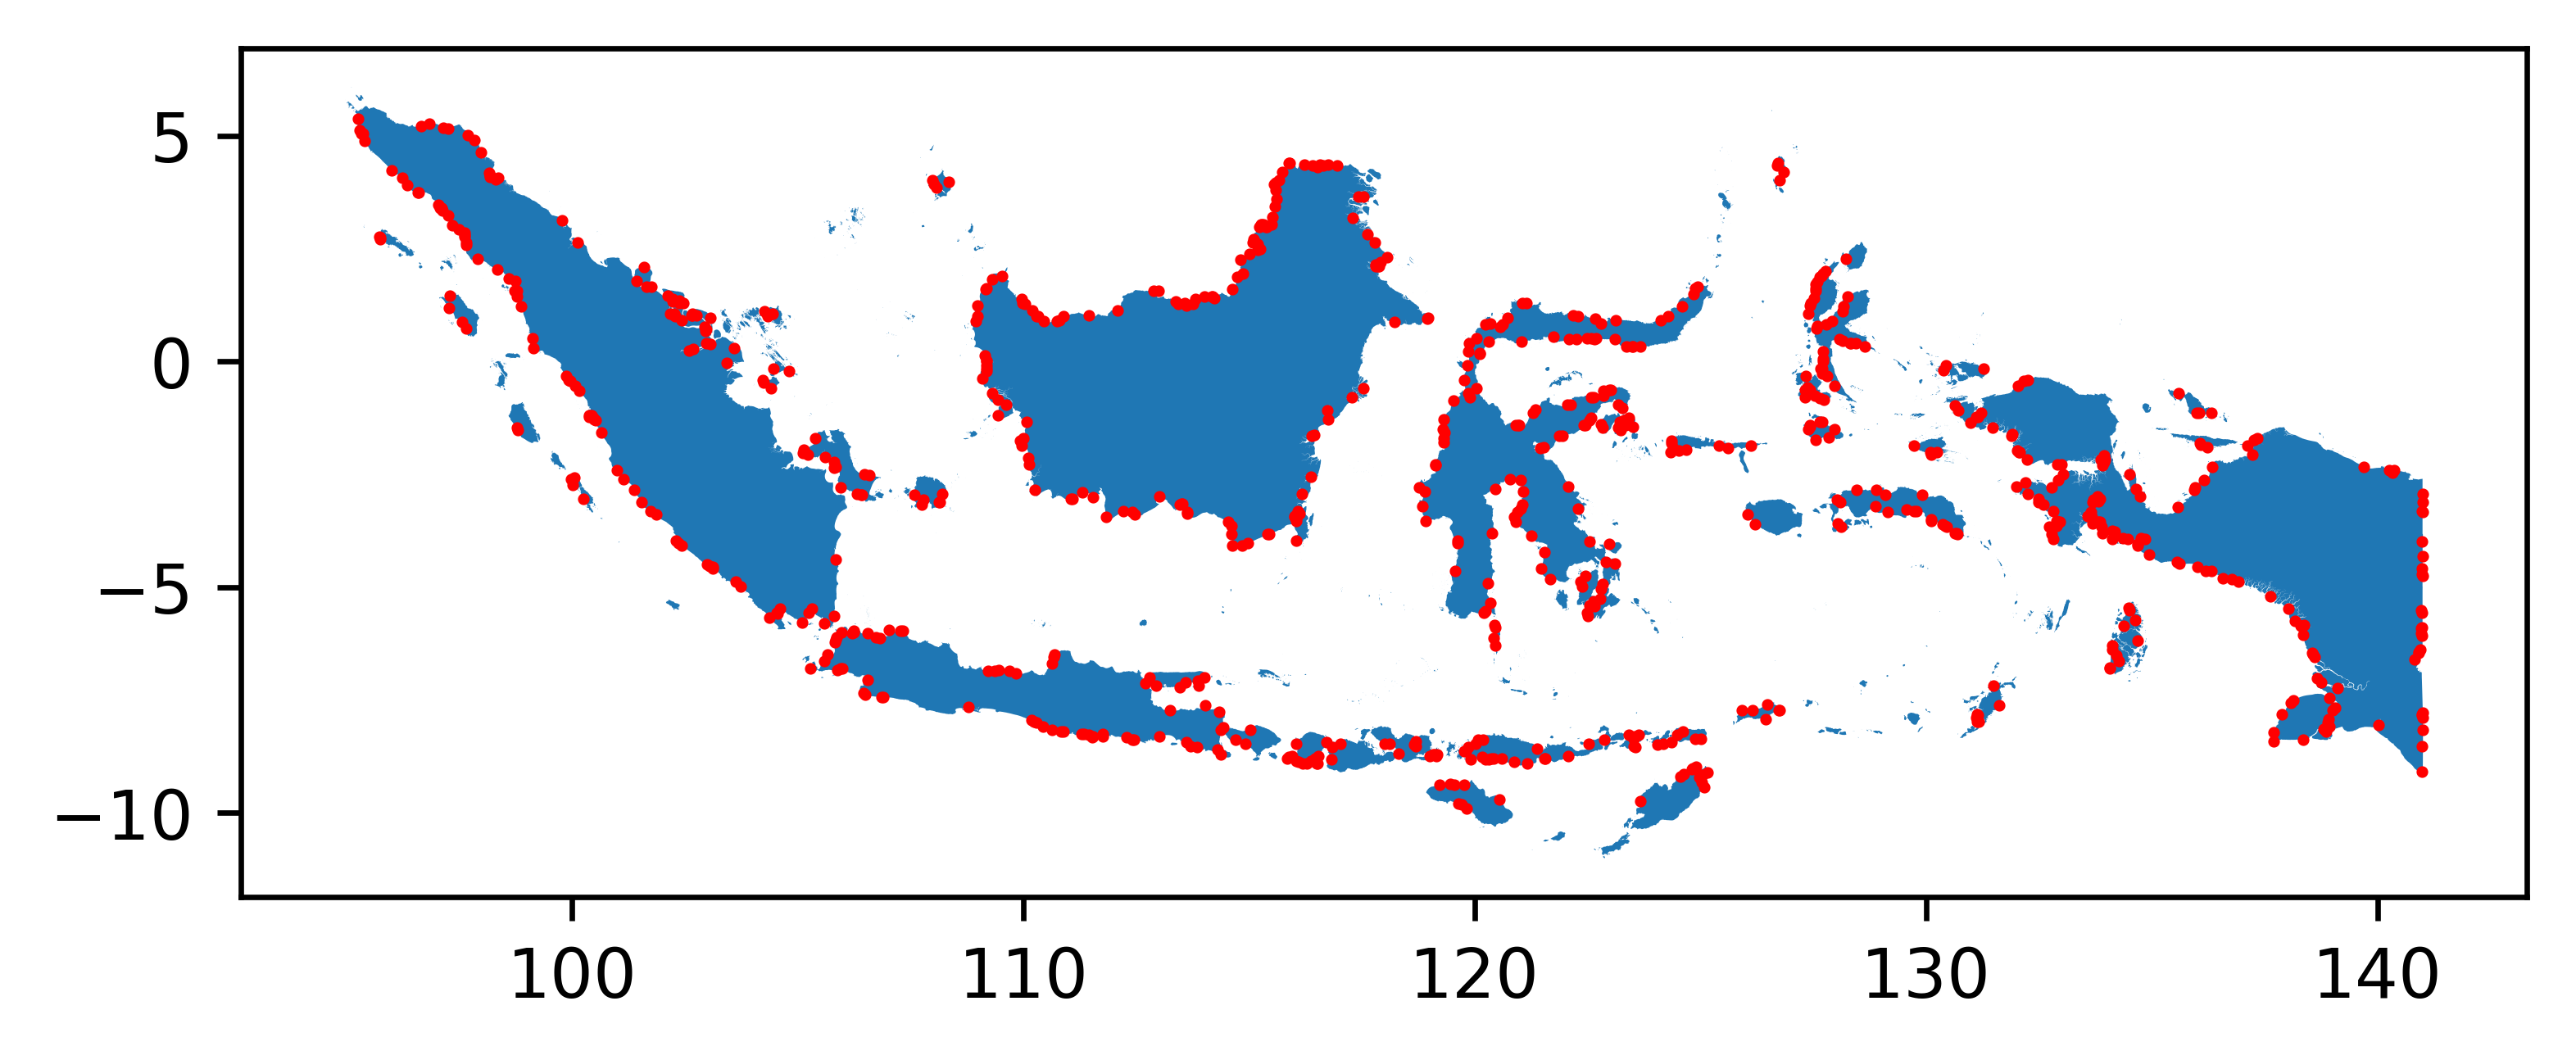

In [161]:
# make plot
fig = plt.figure()
ax = plt.subplot(111)

indonesia.plot(ax=ax)


# for col in cell_options:
#     filtered_subset.set_geometry(col).plot(ax=ax, facecolor="none", edgecolor='orange', lw=0.7)
filtered_subset.set_geometry("coord").plot(ax=ax, color='red', markersize = .5) # plot the selected subset of cells on the border

plt.axis('scaled')

# label points
# for i in range(len(filtered_subset)):
#     plt.annotate(text=str(filtered_subset['id'].iloc[i,]) + ":" + str(int(filtered_subset['area'].iloc[i,])), xy=(filtered_subset['geo_x'].iloc[i,], filtered_subset['geo_y'].iloc[i,]), fontsize=5)

plt.show()


In [157]:
# calculate intersection areas
# https://gis.stackexchange.com/questions/251812/returning-percentage-of-area-of-polygon-intersecting-another-polygon-using-shape

intersections = [[], [], [], [], []]
for ind, option in enumerate(cell_options):
    for i in range(len(filtered_subset)):
        shape = filtered_subset[option][i]
        intersections[ind].append(shape.intersection(indonesia_shape).area)

# ("bl_square", "br_square", "tl_square", "tr_square", "center_square") 

filtered_subset['bl_intersect'] = intersections[0]
filtered_subset['br_intersect'] = intersections[1]
filtered_subset['tl_intersect'] = intersections[2]
filtered_subset['tr_intersect'] = intersections[3]
filtered_subset['center_intersect'] = intersections[4]

# calculate residuals
filtered_subset['bl_residual'] = filtered_subset['bl_intersect'] - filtered_subset['area_degs_estimate']
filtered_subset['br_residual'] = filtered_subset['br_intersect'] - filtered_subset['area_degs_estimate']
filtered_subset['tl_residual'] = filtered_subset['tl_intersect'] - filtered_subset['area_degs_estimate']
filtered_subset['tr_residual'] = filtered_subset['tr_intersect'] - filtered_subset['area_degs_estimate']
filtered_subset['center_residual'] = filtered_subset['center_intersect'] - filtered_subset['area_degs_estimate']


In [68]:
# approx_areas = []
# for i in range(len(filtered_subset)):
#     areas.append(filtered_subset['center_square'][i].area)
# print(np.mean(areas), np.std(areas))
# print(areas)


In [158]:
# areas = sorted(list(filtered_subset['area']))
# plt.scatter(range(len(areas)), areas)

# areas_df = filtered_subset.iloc[:, -6:0]
print(filtered_subset.columns)
keep = ['id', 'area_degs_estimate', 'bl_intersect', 'br_intersect', 'tl_intersect',
       'tr_intersect', 'center_intersect', 'bl_residual', 'br_residual',
       'tl_residual', 'tr_residual', 'center_residual']
# areas_df = filtered_subset.loc[:, keep]
# areas_df.sort_values(by="area_degs_estimate", inplace=True, ignore_index=True)
# areas_df
# save df as a csv file
filtered_subset.loc[:, keep].to_csv("outputs/filtered_subset_analysis.csv")

Index(['id', 'cellcode', 'geo_x', 'geo_y', 'area', 'area_degs_estimate',
       'coord', 'bl_square', 'br_square', 'tl_square', 'tr_square',
       'center_square', 'bl_intersect', 'br_intersect', 'tl_intersect',
       'tr_intersect', 'center_intersect', 'bl_residual', 'br_residual',
       'tl_residual', 'tr_residual', 'center_residual'],
      dtype='object')


In [126]:
residual_col_names = ['bl_residual', 'br_residual', 'tl_residual', 'tr_residual', 'center_residual']
avg_squared_errs = {col:np.mean(areas_df[col]**2) for col in residual_col_names} 
avg_squared_errs

{'bl_residual': 6.381845447953934e-08,
 'br_residual': 9.429838053441485e-08,
 'tl_residual': 4.998581562591947e-08,
 'tr_residual': 1.0885441432364765e-07,
 'center_residual': 3.095865443732614e-08}

bl_residual count    25.000000
mean      0.000080
std       0.000245
min      -0.000342
25%      -0.000069
50%       0.000060
75%       0.000243
max       0.000613
Name: bl_residual, dtype: float64
br_residual count    25.000000
mean      0.000093
std       0.000299
min      -0.000507
25%      -0.000068
50%       0.000049
75%       0.000301
max       0.000611
Name: br_residual, dtype: float64
tl_residual count    25.000000
mean     -0.000018
std       0.000227
min      -0.000311
25%      -0.000167
50%      -0.000069
75%       0.000076
max       0.000550
Name: tl_residual, dtype: float64
tr_residual count    25.000000
mean      0.000003
std       0.000337
min      -0.000550
25%      -0.000246
50%      -0.000052
75%       0.000301
max       0.000618
Name: tr_residual, dtype: float64
center_residual count    25.000000
mean      0.000062
std       0.000168
min      -0.000195
25%      -0.000015
50%       0.000049
75%       0.000087
max       0.000599
Name: center_residual, dtype: float64


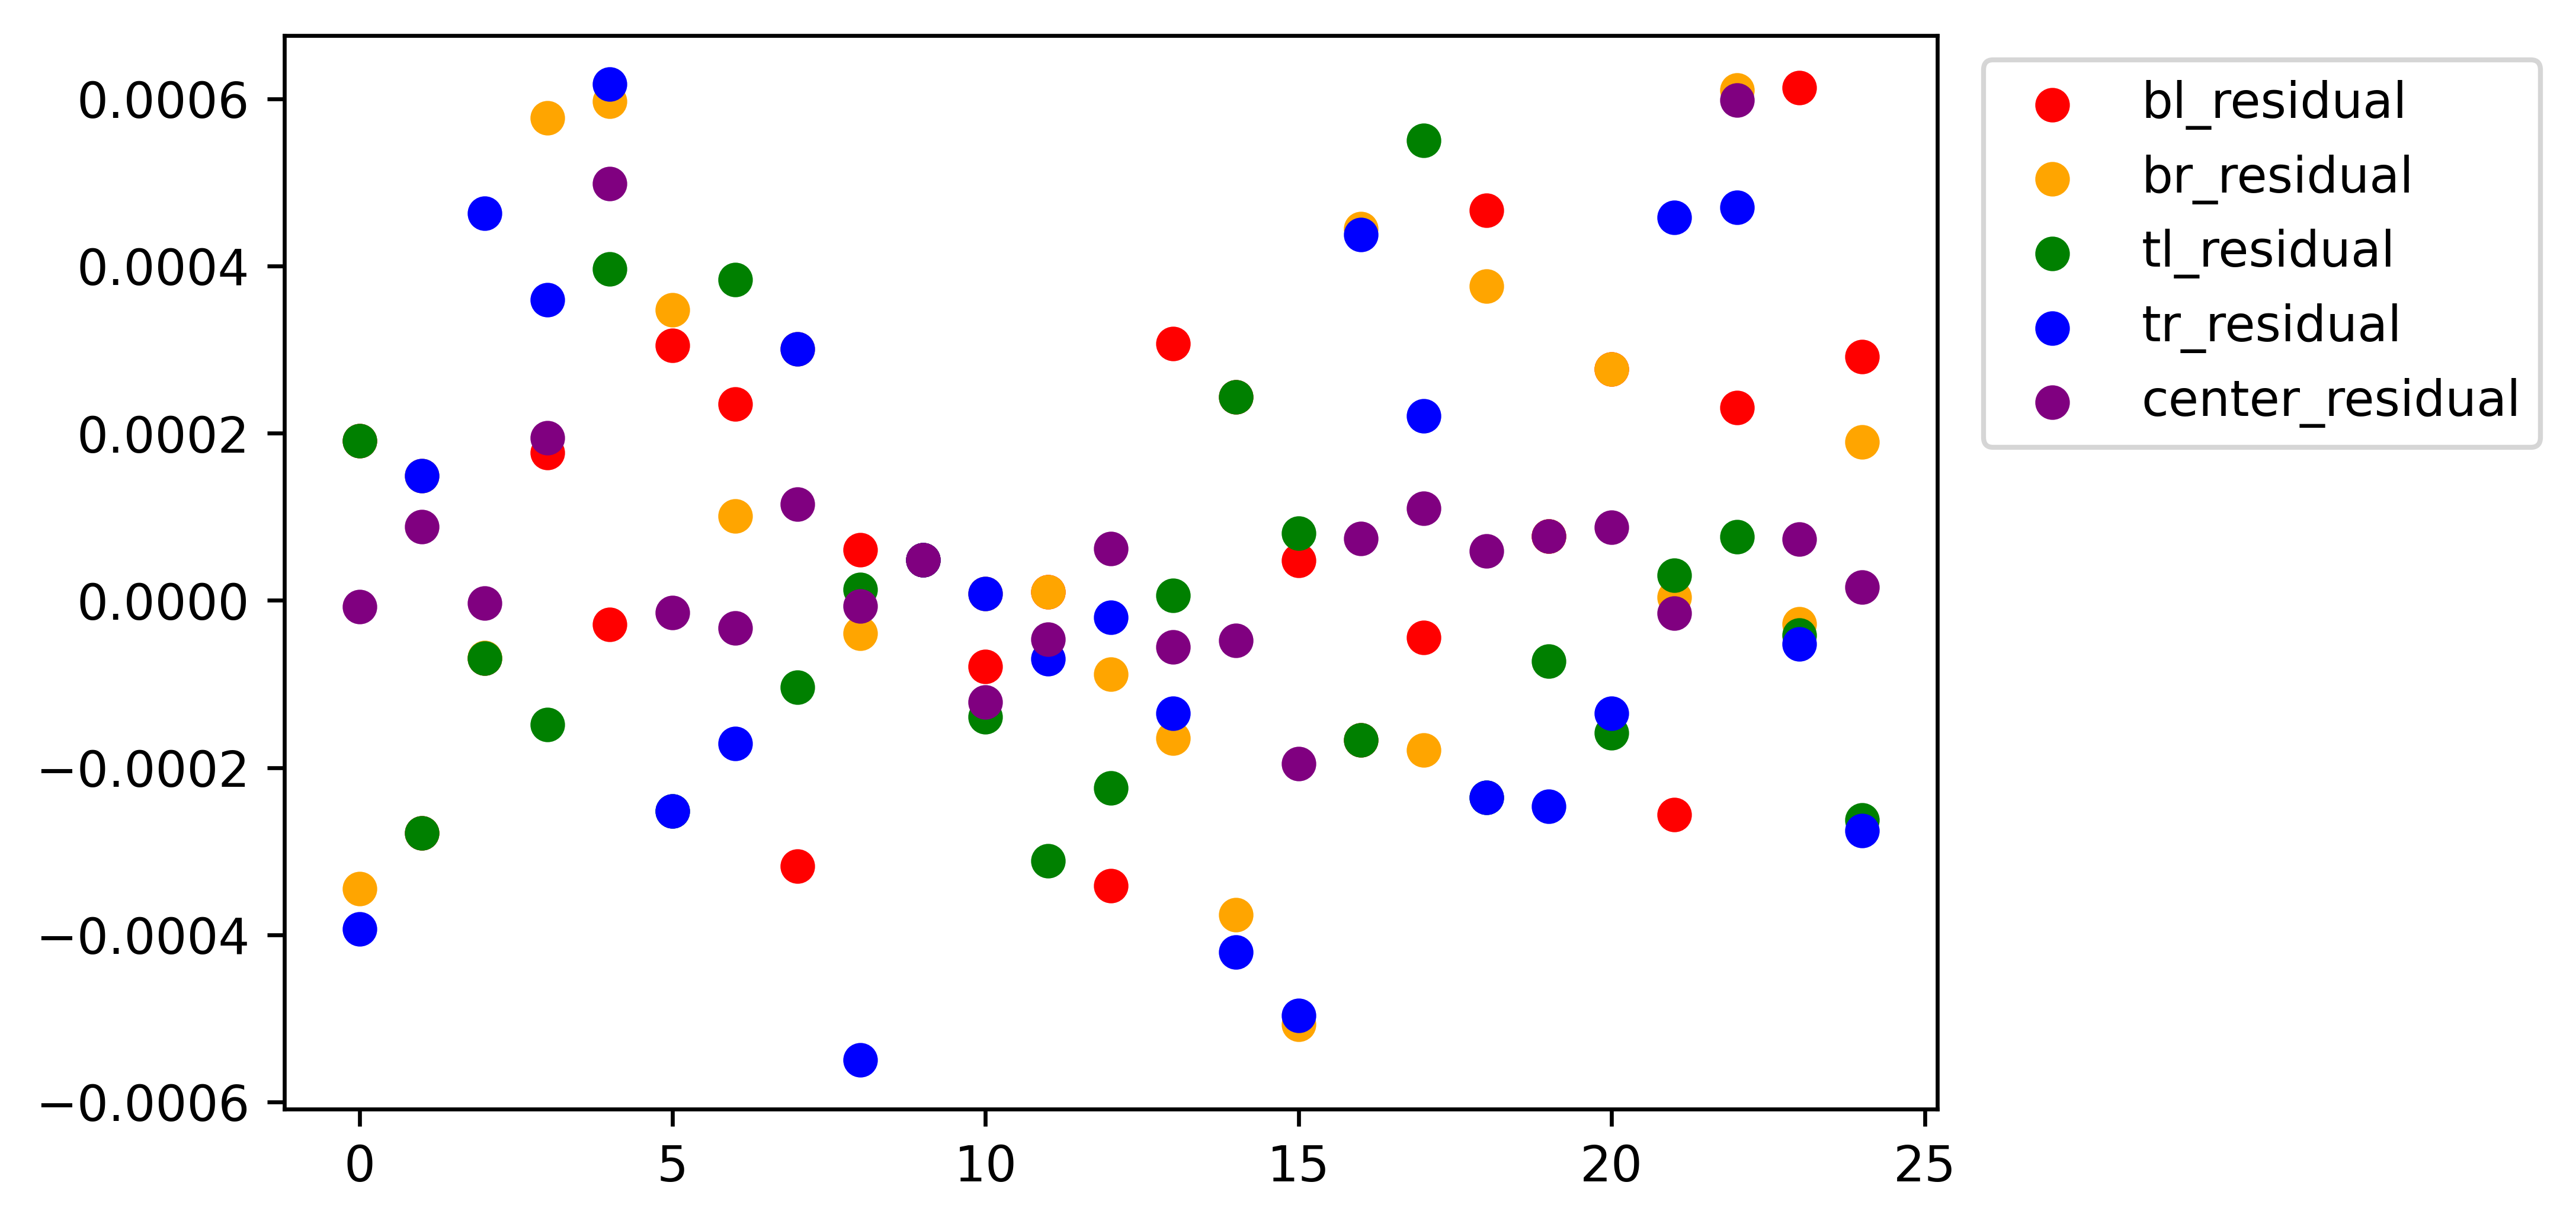

In [140]:
# plot residuals
# this is kind of hard to look at, reference excel file graph instead
color = ["red", "orange", "green", "blue", "purple"]
x=range(len(filtered_subset))
for i, col in enumerate(residual_col_names):
    print(col, filtered_subset[col].describe())
    plt.scatter(x=x, y=filtered_subset[col], color=color[i], label=col)
plt.legend(bbox_to_anchor=(1.38,1), loc="upper right")